In [862]:
import os
import sys
import importlib
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn


import requests
from bs4 import BeautifulSoup
from selenium import webdriver

import redfin
import homepricemodels

importlib.reload(redfin)
importlib.reload(homepricemodels)



pd.set_option('display.max_columns', None)
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.1f' % x)



In [863]:
!pwd
!ls


/Users/timcodes/ds/metis/metisgh/02_Luther/Luther
LICENSE                         geckodriver.log
README.md                       homepricemodels.py
__pycache__                     pickles
explore_linear_regression.ipynb redfin.py
explore_luther.ipynb            redfin_2018-04-18-08-51-54.csv


In [864]:
#redfin.combine_zipcode_listings_pickles_into_one(pickle_directory='pickles/')

In [865]:
redfin.scrape_home_stats(list_of_relative_urls=None, pickle_directory='pickles/', save_every=250)

List of relative URLS is NONE, loading default data set.
Processing link #0: /CA/Los-Angeles/1440-Veteran-Ave-90024/unit-570/home/6803084
Processing link #1: /CA/Oakland/1903-25th-Ave-94601/home/1457806
Processing link #2: /CA/Oakland/4019-E-16th-St-94601/home/1422485
Processing link #3: /CA/Oakland/3932-Loma-Vista-Ave-94619/home/546802
Processing link #4: /CA/Oakland/2023-92nd-Ave-94603/home/1649686
Processing link #5: /CA/Berkeley/2610-Woolsey-St-94705/home/531402
Processing link #6: /CA/Oakland/3315-Wilson-Pl-94602/home/571303
Processing link #7: /CA/Oakland/3815-Laguna-Ave-94602/home/542524
Processing link #8: /CA/Oakland/3229-Ardley-Ave-94602/home/1992643
Processing link #9: /CA/Los-Angeles/10633-Kinnard-Ave-90024/unit-18/home/6805375
Processing link #10: /CA/Oakland/3035-Lynde-St-94601/home/1496675
Processing link #11: /CA/Oakland/5606-Taft-Ave-94618/home/631853
Processing link #12: /CA/Oakland/2347-E-20th-St-94601/home/1820365
Processing link #13: /CA/Los-Angeles/6120-Flight-Ave

Processing link #114: /CA/Los-Angeles/800-N-Orlando-Ave-90069/home/7105181
Processing link #115: /CA/Los-Angeles/2244-Aaron-St-90026/home/22160735
Processing link #116: /CA/Oakland/739-Campbell-St-94607/home/22657620
Processing link #117: /CA/Oakland/2223-E-23rd-St-94606/home/1329197
Processing link #118: /CA/Los-Angeles/3818-Carnavon-Way-90027/home/7135895
Processing link #119: /CA/Los-Angeles/1647-Waterloo-St-90026/home/7057534
Processing link #120: /CA/Oakland/11101-Robledo-Dr-94603/home/1925648
Processing link #121: /CA/Oakland/3084-22nd-Ave-94602/unit-4/home/16883377
Processing link #122: /CA/Los-Angeles/5025-College-View-Ave-90041/home/7176409
Processing link #123: /CA/Oakland/4019-Mera-St-94601/home/551962
Processing link #124: /CA/Oakland/3511-Victor-Ave-94619/home/546400
Processing link #125: /CA/Los-Angeles/740-N-Kings-Rd-90069/unit-322/home/7104385
Processing link #126: /CA/Oakland/2155-47th-Ave-94601/home/1743048
Processing link #127: /CA/Los-Angeles/2035-De-Mille-Dr-90027/

Processing link #227: /CA/Los-Angeles/4311-Finley-Ave-90027/home/7135115
Processing link #228: /CA/Oakland/4121-Webster-St-94609/home/879481
Processing link #229: /CA/Oakland/1011-Wood-St-94607/home/999210
Processing link #230: /CA/Los-Angeles/10501-Wilshire-Blvd-90024/unit-903/home/17233277
Processing link #231: /CA/Los-Angeles/5032-Mosaic-Ct-90041/home/51586583
Processing link #232: /CA/Oakland/5448-Roberts-Ave-94619/home/1962893
Processing link #233: /CA/Culver-City/3149-Roberts-Ave-90232/home/6721191
Processing link #234: /CA/Culver-City/3427-Sherbourne-Dr-90232/home/6793485
Processing link #235: /CA/Oakland/945-90th-Ave-94603/home/581712
Processing link #236: /CA/Oakland/4300-Terrabella-Way-94619/home/1363073
Processing link #237: /CA/Compton/4933-E-San-Rafael-St-90221/home/7364386
Processing link #238: /CA/West-Hollywood/848-N-Kings-Rd-90069/unit-110/home/7105283
Processing link #239: /CA/Los-Angeles/2915-Acresite-St-90039/home/7066388
Processing link #240: /CA/Oakland/2530-14th-

Processing link #340: /CA/Culver-City/3008-Sentney-Ave-90232/home/6721090
Processing link #341: /CA/Los-Angeles/827-Micheltorena-St-90026/home/7060172
Processing link #342: /CA/Oakland/730-29th-St-94609/unit-C12/home/107605789
Processing link #343: /CA/Oakland/2416-25th-Ave-94601/home/1924917
Processing link #344: /CA/Oakland/5248-Redondo-Ave-94618/home/529537
Processing link #345: /CA/Oakland/1908-Melvin-Rd-94602/home/678115
Processing link #346: /CA/Oakland/3101-Guido-St-94602/home/544262
Processing link #347: /CA/Oakland/555-Aileen-St-94609/home/2017157
Processing link #348: /CA/Compton/409-S-Harris-Ave-90221/home/7361931
Processing link #349: /CA/Los-Angeles/4926-La-Roda-Ave-90041/home/143162086
Processing link #350: /CA/Los-Angeles/6108-S-Le-Doux-Rd-90056/home/6596482
Processing link #351: /CA/Compton/1701-E-Tucker-St-90221/home/7363831
Processing link #352: /CA/Compton/14819-S-Lime-Ave-90221/home/7364144
Processing link #353: /CA/Oakland/222-Broadway-94607/unit-1108/home/28696706

Processing link #453: /CA/Oakland/1437-25th-Ave-94601/home/2013496
Processing link #454: /CA/Oakland/2491-Cole-St-94601/home/1607360
Processing link #455: /CA/Oakland/3101-Madeline-St-94602/home/540664
Processing link #456: /CA/West-Hollywood/972-Larrabee-St-90069/unit-219/home/6817893
Processing link #457: /CA/Los-Angeles/3151-Madera-Ave-90039/home/7065866
Processing link #458: /CA/Los-Angeles/1725-Griffith-Park-Blvd-90026/home/7060461
Processing link #459: /CA/Los-Angeles/10626-Holman-Ave-90024/unit-3A/home/109322022
Processing link #460: /CA/Los-Angeles/237-Welcome-St-90026/home/6936561
Processing link #461: /CA/Los-Angeles/2343-Las-Colinas-Ave-90041/home/7178410
Processing link #462: /CA/Oakland/702-33rd-St-94609/home/1531641
Processing link #463: /CA/Los-Angeles/3241-Lowry-Rd-90027/home/7134901
Processing link #464: /CA/West-Hollywood/1015-N-Kings-Rd-90069/unit-219/home/113218507
Processing link #465: /CA/Oakland/715-Fallon-St-94607/home/524552
Processing link #466: /CA/Los-Angele

Processing link #565: /CA/Oakland/3334-Noyo-St-94602/home/1910724
Processing link #566: /CA/Oakland/2733-25th-Ave-94601/home/617950
Processing link #567: /CA/Oakland/2520-Carmel-St-94602/home/1630957
Processing link #568: /CA/Compton/813-N-Bradfield-Ave-90221/home/7363561
Processing link #569: /CA/Oakland/432-50th-St-94609/home/536117
Processing link #570: /CA/Oakland/428-Alice-St-94607/unit-306/home/12116050
Processing link #571: /CA/Los-Angeles/10794-Wilkins-Ave-90024/unit-101/home/6803754
Processing link #572: /CA/Compton/14909-S-Cookacre-St-90221/home/7370173
Processing link #573: /CA/Culver-City/4222-Mentone-Ave-90232/home/6723612
Processing link #574: /CA/Oakland/730-29th-St-94609/unit-4C/home/22963729
Processing link #575: /CA/Oakland/615-Cleveland-St-94606/home/1726582
Processing link #576: /CA/Los-Angeles/8570-Hillside-Ave-90069/home/22322938
Processing link #577: /CA/Oakland/5479-Cole-St-94601/home/556601
Processing link #578: /CA/Oakland/1427-Pullman-Way-94607/home/112885451

Processing link #678: /CA/Oakland/331-49th-St-94609/home/40627068
Processing link #679: /CA/Oakland/1794-8th-St-94607/home/2040019
Processing link #680: /CA/Oakland/40-Westminster-Dr-94618/home/773691
Processing link #681: /CA/Oakland/2536-High-St-94601/home/630576
Processing link #682: /CA/Los-Angeles/1340-S-Beverly-Glen-Blvd-90024/unit-207/home/6806839
Processing link #683: /CA/Oakland/3814-Clarke-St-94609/home/1816199
Processing link #684: /CA/Oakland/4011-Penniman-Ave-94619/home/550941
Processing link #685: /CA/Oakland/4320-Terrabella-Way-94619/home/22715941
Processing link #686: /CA/Oakland/1012-Galvin-St-94602/home/536036
Processing link #687: /CA/Oakland/3912-Webster-St-94609/home/1888153
Processing link #688: /CA/Oakland/5300-Estates-Dr-94618/home/612378
Processing link #689: /CA/Los-Angeles/10433-Wilshire-Blvd-90024/unit-301/home/6826537
Processing link #690: /CA/Los-Angeles/10590-Wilshire-Blvd-90024/unit-703/home/6804373
Processing link #691: /CA/Culver-City/3582-Wesley-St-90

Processing link #791: /CA/Oakland/2318-7th-Ave-94606/home/1861963
Processing link #792: /CA/Oakland/2612-9th-Ave-94606/home/534593
Processing link #793: /CA/Oakland/3701-Wisconsin-St-94619/home/660391
Processing link #794: /CA/Los-Angeles/3216-Rowena-Ave-90027/home/7062933
Processing link #795: /CA/Los-Angeles/1716-Micheltorena-St-90026/home/7062055
Processing link #796: /CA/Los-Angeles/1426-Prism-Dr-90041/home/103997119
Processing link #797: /CA/Los-Angeles/3310-Larissa-Dr-90026/home/7059221
Processing link #798: /CA/Los-Angeles/4139-Camero-Ave-90027/home/7060834
Processing link #799: /CA/Oakland/5525-Carlton-St-94618/home/1776027
Processing link #800: /CA/Los-Angeles/540-Woodruff-Ave-90024/home/102926484
Processing link #801: /CA/Los-Angeles/419-N-Coronado-St-90026/home/6935955
Processing link #802: /CA/Los-Angeles/4844-Wicopee-St-90041/home/7180047
Processing link #803: /CA/Oakland/2136-Linden-St-94607/home/525064
Processing link #804: /CA/Oakland/3878-Fruitvale-Ave-94602/home/74735

Processing link #903: /CA/Los-Angeles/2753-Waverly-Dr-90039/unit-805-62/home/143183407
Processing link #904: /CA/Los-Angeles/2109-Valentine-St-90026/home/7056806
Processing link #905: /CA/Los-Angeles/5119-Fountain-Ave-90029/home/7112800
Processing link #906: /CA/Oakland/734-Peralta-St-94607/home/1617577
Processing link #907: /CA/Los-Angeles/3373-Rowena-Ave-90027/home/7063515
Processing link #908: /CA/Oakland/4291-Coolidge-Ave-94602/home/690711
Processing link #909: /CA/Los-Angeles/2980-Waverly-Dr-90039/home/7063876
Processing link #910: /CA/Los-Angeles/5817-Wooster-Ave-90056/home/8149662
Processing link #911: /CA/Culver-City/4044-Coogan-Cir-90232/home/6722966
Processing link #912: /CA/Los-Angeles/5529-S-La-Cienega-Blvd-90056/unit-12A/home/6718589
Processing link #913: /CA/Oakland/4162-Culver-St-94619/home/1820724
Processing link #914: /CA/Los-Angeles/5042-Los-Robles-St-90041/home/7179918
Processing link #915: /CA/Oakland/2815-Eastman-Ave-94619/home/1323154
Processing link #916: /CA/Los

Processing link #1015: /CA/Los-Angeles/10520-Wilshire-Blvd-90024/unit-1204/home/6804599
Processing link #1016: /CA/Culver-City/9615-Lucerne-Ave-90232/home/6722276
Processing link #1017: /CA/Oakland/460-63rd-St-94609/home/90534897
Processing link #1018: /CA/Berkeley/1570-Grand-View-Dr-94705/home/40087571
Processing link #1019: /CA/Los-Angeles/2387-Teviot-St-90039/home/7067302
Processing link #1020: /CA/Oakland/1893-Melvin-Rd-94602/home/1532782
Processing link #1021: /CA/Oakland/1334-104th-Ave-94603/home/1903023
Processing link #1022: /CA/Los-Angeles/1596-Waldran-Ave-90041/home/7179494
Processing link #1023: /CA/Oakland/4117-Penniman-Ct-94619/unit-F/home/1667195
Processing link #1024: /CA/Los-Angeles/4979-Vincent-Ave-90041/home/7179432
Processing link #1025: /CA/Oakland/674-Poirier-St-94609/home/1726972
Processing link #1026: /CA/Los-Angeles/6401-S-Sherbourne-Dr-90056/home/6596666
Processing link #1027: /CA/Los-Angeles/5302-Loleta-Ave-90041/home/7180416
Processing link #1028: /CA/Oakland

Processing link #1126: /CA/Los-Angeles/3231-Madera-Ave-90039/home/7065874
Processing link #1127: /CA/Oakland/5006-Fleming-Ave-94619/home/786751
Processing link #1128: /CA/Los-Angeles/6141-Bedford-Ave-90056/home/6595500
Processing link #1129: /CA/Los-Angeles/10751-Wilshire-Blvd-90024/unit-1007/home/77304973
Processing link #1130: /CA/Compton/520-N-Poinsettia-Ave-90221/home/7361094
Processing link #1131: /CA/Culver-City/4181-Lincoln-Ave-90232/home/6722122
Processing link #1132: /CA/Oakland/2950-Morcom-Ave-94619/home/922607
Processing link #1133: /CA/Oakland/574-48th-St-94609/unit-304/home/12116407
Processing link #1134: /CA/Oakland/3090-Glascock-St-94601/unit-121/home/12115655
Processing link #1135: /CA/Oakland/626-Alcatraz-Ave-94609/unit-A/home/12115885
Processing link #1136: /CA/Los-Angeles/1301-Waterloo-St-90026/home/7058456
Processing link #1137: /CA/Oakland/536-Almanza-Dr-94603/home/945015
Processing link #1138: /CA/Oakland/5081-Congress-Ave-94601/home/555640
Processing link #1139: 

Processing link #1237: /CA/Los-Angeles/4911-Townsend-Ave-90041/home/7179410
Processing link #1238: /CA/Los-Angeles/4559-Alumni-Ave-90041/home/7080042
Processing link #1239: /CA/Culver-City/4168-Baldwin-Ave-90232/home/6722064
Processing link #1240: /CA/Los-Angeles/10490-Wilshire-Blvd-90024/unit-2303/home/6806393
Processing link #1241: /CA/Oakland/10112-Dante-Ave-94603/home/598535
Processing link #1242: /CA/Culver-City/4225-Lafayette-Pl-90232/home/6722287
Processing link #1243: /CA/West-Hollywood/967-Hammond-St-90069/unit-11/home/6819062
Processing link #1244: /CA/Oakland/5844-Broadway-94618/home/1717086
Processing link #1245: /CA/Oakland/4026-Midvale-Ave-94602/home/544525
Processing link #1246: /CA/Los-Angeles/3704-Prestwick-Dr-90027/home/7135913
Processing link #1247: /CA/Oakland/1245-94th-Ave-94603/home/88154072
Processing link #1248: /CA/Los-Angeles/2426-Merton-Ave-90041/home/7176374
Processing link #1249: /CA/Los-Angeles/5336-Bedford-Ave-90056/home/6719036
Processing link #1250: /CA

Processing link #1349: /CA/Culver-City/5926-Wrightcrest-Dr-90232/home/8090630
Processing link #1350: /CA/Oakland/1041-102nd-Ave-94603/home/1517186
Processing link #1351: /CA/Los-Angeles/2408-Nottingham-Ave-90027/home/7132391
Processing link #1352: /CA/Oakland/2-Fieldbrook-Pl-94619/home/1589702
Processing link #1353: /CA/Oakland/280-Caldecott-Ln-94618/unit-202/home/628763
Processing link #1354: /CA/OAKLAND/TUNNEL-RD-94603/home/143116525
Processing link #1355: /CA/Oakland/1729-Filbert-St-94607/home/525252
Processing link #1356: /CA/Los-Angeles/10800-Holman-Ave-90024/unit-207/home/6804046
Processing link #1357: /CA/Los-Angeles/3335-Rowena-Ave-90027/home/7063537
Processing link #1358: /CA/Oakland/4093-Waterhouse-Rd-94602/home/1642111
Processing link #1359: /CA/Culver-City/4284-Motor-Ave-90232/home/6723431
Processing link #1360: /CA/Oakland/479-Clifton-St-94618/home/1986418
Processing link #1361: /CA/Los-Angeles/3161-Rowena-Ave-90027/home/7063665
Processing link #1362: /CA/Los-Angeles/4211-

Processing link #1460: /CA/West-Hollywood/911-N-Kings-Rd-90069/unit-202/home/7105477
Processing link #1461: /CA/Compton/2127-E-San-Vincente-St-90221/home/7363915
Processing link #1462: /CA/West-Hollywood/906-N-Doheny-Dr-90069/unit-415/home/6818968
Processing link #1463: /CA/Los-Angeles/1732-Westerly-Ter-90026/home/7062273
Processing link #1464: /CA/Oakland/5680-Estates-Dr-94618/home/1330779
Processing link #1465: /CA/Los-Angeles/10982-Roebling-Ave-90024/unit-D/home/8102436
Processing link #1466: /CA/Los-Angeles/3210-Drury-Ln-90039/home/7061699
Processing link #1467: /CA/Los-Angeles/8634-Hillside-Ave-90069/home/7120240
Processing link #1468: /CA/Los-Angeles/6006-Wooster-Ave-90056/home/6596300
Processing link #1469: /CA/Oakland/280-Caldecott-Ln-94618/unit-214/home/1517757
Processing link #1470: /CA/Oakland/344-Alcatraz-Ave-94618/home/659419
Processing link #1471: /CA/Oakland/9982-Empire-Rd-94603/home/1607984
Processing link #1472: /CA/West-Hollywood/8530-Holloway-Dr-90069/unit-311/home/6

Processing link #1569: /CA/Culver-City/4196-Mentone-Ave-90232/home/6723592
Processing link #1570: /CA/Oakland/616-Hillsborough-St-94606/home/1699078
Processing link #1571: /CA/Oakland/2336-Magnolia-St-94607/unit-9/home/112885424
Processing link #1572: /CA/Los-Angeles/8651-Pine-Tree-Pl-90069/home/7120800
Processing link #1573: /CA/West-Hollywood/1145-Larrabee-St-90069/unit-20/home/7121538
Processing link #1574: /CA/Oakland/Undisclosed-address-94601/home/2114829
Processing link #1575: /CA/Oakland/6011-Rockridge-Blvd-94618/home/1162113
Processing link #1576: /CA/Oakland/819-Clay-St-94607/home/2113200
Processing link #1577: /CA/Oakland/4624-Steele-St-94619/home/1654897
Processing link #1578: /CA/Los-Angeles/1440-Veteran-Ave-90024/unit-554/home/6803068
Processing link #1579: /CA/Culver-City/9048-Carson-St-90232/home/6721573
Processing link #1580: /CA/Compton/809-N-Santa-Fe-Ave-90221/home/7355297
Processing link #1581: /CA/Oakland/2575-Fruitvale-Ave-94601/home/1702098
Processing link #1582: 

Processing link #1679: /CA/Oakland/1241-E-18th-St-94606/home/1432267
Processing link #1680: /CA/Compton/1205-E-Tichenor-St-90221/home/7354527
Processing link #1681: /CA/Los-Angeles/306-N-Bixel-St-90026/home/6936954
Processing link #1682: /CA/Oakland/311-Oak-St-94607/unit-113/home/12350317
Processing link #1683: /CA/Los-Angeles/3832-Shannon-Rd-90027/home/7135925
Processing link #1684: /CA/Compton/14907-S-White-Ave-90221/home/7370140
Processing link #1685: /CA/Los-Angeles/1249-Colton-St-90026/home/21925552
Processing link #1686: /CA/Oakland/5812-Ayala-Ave-94609/home/95473114
Processing link #1687: /CA/Oakland/4124-Gregory-St-94619/home/2025678
Processing link #1688: /CA/West-Hollywood/1222-N-Kings-Rd-90069/unit-8/home/7118236
Processing link #1689: /CA/Oakland/2256-High-St-94601/home/1716275
Processing link #1690: /CA/Compton/4917-E-San-Miguel-St-90221/home/7364480
Processing link #1691: /CA/Oakland/4601-Redding-St-94619/home/1224177
Processing link #1692: /CA/Los-Angeles/2143-Lemoyne-St

Processing link #1790: /CA/Oakland/6678-Charing-Cross-Rd-94618/home/1324285
Processing link #1791: /CA/Oakland/3690-Butters-Dr-94602/home/1855775
Processing link #1792: /CA/Los-Angeles/5052-Franklin-Ave-90027/home/7134125
Processing link #1793: /CA/Oakland/2207-48th-Ave-94601/home/558308
Processing link #1794: /CA/Los-Angeles/914-N-Vendome-St-90026/home/7059450
Processing link #1795: /CA/Oakland/1021-Elbert-St-94602/home/1831227
Processing link #1796: /CA/Oakland/531-53rd-St-94609/home/529968
Processing link #1797: /CA/Oakland/2875-Glascock-St-94601/unit-112/home/2042920
Processing link #1798: /CA/Los-Angeles/203-N-Vendome-St-90026/home/6935584
Processing link #1799: /CA/Compton/1820-E-McMillan-St-90221/home/7363592
Processing link #1800: /CA/Oakland/1563-Chandler-St-94603/unit-108/home/1042069
Processing link #1801: /CA/Oakland/580-56th-St-94609/home/530128
Processing link #1802: /CA/Los-Angeles/1631-N-Harvard-Blvd-90027/unit-9/home/7112529
Processing link #1803: /CA/Los-Angeles/1800-

Processing link #1900: /CA/Oakland/10565-East-Ct-94603/home/1341971
Processing link #1901: /CA/Oakland/3066-Dakota-St-94602/home/540640
Processing link #1902: /CA/Oakland/807-Brooklyn-Ave-94606/home/2025555
Processing link #1903: /CA/Los-Angeles/4717-Townsend-Ave-90041/home/7179790
Processing link #1904: /CA/Los-Angeles/4114-Edenhurst-Ave-90039/home/7136804
Processing link #1905: /CA/Los-Angeles/5862-S-Croft-Ave-90056/home/6403097
Processing link #1906: /CA/Culver-City/4163-Center-St-90232/home/6726604
Processing link #1907: /CA/Los-Angeles/6118-Damask-Ave-90056/home/6405172
Processing link #1908: /CA/Los-Angeles/1637-Lake-Shore-Ave-90026/home/7055473
Processing link #1909: /CA/Oakland/638-62nd-St-94609/home/2004994
Processing link #1910: /CA/Oakland/1431-Pullman-Way-94607/home/112885405
Processing link #1911: /CA/Oakland/2040-11th-Ave-94606/home/533254
Processing link #1912: /CA/West-Hollywood/8948-Dicks-St-90069/home/6818635
Processing link #1913: /CA/Los-Angeles/2168-Lyric-Ave-90027

Processing link #2011: /CA/Los-Angeles/3705-Lowry-Rd-90027/home/7135885
Processing link #2012: /CA/Los-Angeles/3107-Scotland-St-90039/home/7062365
Processing link #2013: /CA/Oakland/705-Zephyr-Dr-94607/home/22682831
Processing link #2014: /CA/Oakland/680-42nd-St-94609/home/1431824
Processing link #2015: /CA/Culver-City/4048-Jackson-Ave-90232/home/6722011
Processing link #2016: /CA/Oakland/9244-C-St-94603/home/1975382
Processing link #2017: /CA/Los-Angeles/6750-Radlock-Ave-90056/home/6597604
Processing link #2018: /CA/Oakland/557-43rd-St-94609/home/530666
Processing link #2019: /CA/Oakland/220-Caldecott-Ln-94618/unit-117/home/627597
Processing link #2020: /CA/Oakland/1520-Leimert-Blvd-94602/home/547294
Processing link #2021: /CA/Los-Angeles/1915-Myra-Ave-90027/home/7135345
Processing link #2022: /CA/Los-Angeles/6644-Radlock-Ave-90056/home/6597539
Processing link #2023: /CA/Oakland/2831-Regatta-Dr-94601/home/2111756
Processing link #2024: /CA/Culver-City/3130-Reid-Ave-90232/home/6721092


Processing link #2121: /CA/Los-Angeles/2503-Panorama-Ter-90039/home/7062409
Processing link #2122: /CA/Los-Angeles/1448-N-Occidental-Blvd-90026/home/7058159
Processing link #2123: /CA/Oakland/3704-West-St-94608/home/1936133
Processing link #2124: /CA/Los-Angeles/10982-Roebling-Ave-90024/unit-512/home/8102382
Processing link #2125: /CA/Oakland/2063-Harrington-Ave-94601/home/1589560
Processing link #2126: /CA/Los-Angeles/2250-Edendale-Pl-90039/home/130665664
Processing link #2127: /CA/Los-Angeles/1442-Sunset-Blvd-90026/home/7053280
Processing link #2128: /CA/Los-Angeles/5051-Argus-Dr-90041/unit-4/home/144831810
Processing link #2129: /CA/Los-Angeles/10660-Wilshire-Blvd-90024/unit-1008/home/6804257
Processing link #2130: /CA/Los-Angeles/1333-S-Beverly-Glen-Blvd-90024/unit-102/home/101682847
Processing link #2131: /CA/Inglewood/5333-W-Amberwood-Dr-90302/home/6599126
Processing link #2132: /CA/Oakland/2420-Palmetto-St-94602/home/540948
Processing link #2133: /CA/Los-Angeles/1680-Hill-Dr-900

Processing link #2232: /CA/Los-Angeles/2815-Griffith-Park-Blvd-90027/home/7063400
Processing link #2233: /CA/Oakland/2911-E-16th-St-94601/home/763968
Processing link #2234: /CA/Los-Angeles/5554-S-Holt-Ave-90056/home/6718658
Processing link #2235: /CA/Los-Angeles/10523-Ashton-Ave-90024/unit-104/home/110141336
Processing link #2236: /CA/Los-Angeles/1859-Yosemite-Dr-90041/home/7178938
Processing link #2237: /CA/West-Hollywood/708-Westbourne-Dr-90069/home/6816832
Processing link #2238: /CA/Los-Angeles/1886-Lucretia-Ave-90026/home/7056564
Processing link #2239: /CA/Oakland/2830-Humboldt-Ave-94602/home/539946
Processing link #2240: /CA/Los-Angeles/1633-N-Easterly-Ter-90026/home/143822906
Processing link #2241: /CA/Los-Angeles/2015-Avon-St-90026/home/7056816
Processing link #2242: /CA/Oakland/4657-Redding-St-94619/home/1702433
Processing link #2243: /CA/Oakland/3534-Randolph-Ave-94602/home/17184850
Processing link #2244: /CA/Oakland/428-Alice-St-94607/unit-331/home/12116056
Processing link #2

Processing link #2343: /CA/Los-Angeles/1443-Bellevue-Ave-90026/home/7053589
Processing link #2344: /CA/Oakland/4410-Edgewood-Ave-94602/unit-C/home/22961938
Processing link #2345: /CA/Oakland/2825-Kingsland-Ave-94619/home/1196248
Processing link #2346: /CA/Oakland/5285-Belvedere-St-94601/home/557213
Processing link #2347: /CA/Oakland/4770-Fair-Ave-94619/home/2044898
Processing link #2348: /CA/Oakland/2332-96th-Ave-94603/home/1330543
Processing link #2349: /CA/West-Hollywood/1250-N-Kings-Rd-90069/unit-407/home/7118201
Processing link #2350: /CA/Oakland/2139-E-19th-St-94606/unit-2/home/1606503
Processing link #2351: /CA/Oakland/1920-17th-Ave-94606/home/532814
Processing link #2352: /CA/Los-Angeles/724-1-2-Lucile-Ave-90026/home/143517634
Processing link #2353: /CA/Oakland/9821-E-St-94603/home/590376
Processing link #2354: /CA/Culver-City/3330-Cattaraugus-Ave-90232/home/6721279
Processing link #2355: /CA/Los-Angeles/1338-North-Avenue-46-90041/home/7080398
Processing link #2356: /CA/Oakland/

Processing link #2454: /CA/Compton/605-S-Sloan-Ave-90221/home/7361636
Processing link #2455: /CA/Los-Angeles/2118-Echo-Park-Ave-90026/home/7056769
Processing link #2456: /CA/West-Hollywood/950-N-Kings-Rd-90069/unit-70/home/7106121
Processing link #2457: /CA/Oakland/25-Templar-Pl-94618/home/1608320
Processing link #2458: /CA/Los-Angeles/10658-Ashton-Ave-90024/home/6804907
Processing link #2459: /CA/Los-Angeles/771-Holmby-Ave-90024/home/6826469
Processing link #2460: /CA/Los-Angeles/10433-Wilshire-Blvd-90024/unit-703/home/6826579
Processing link #2461: /CA/Oakland/1734-20th-Ave-94606/home/1421876
Processing link #2462: /CA/Los-Angeles/3871-Revere-Ave-90039/home/7064113
Processing link #2463: /CA/Los-Angeles/4243-Russell-Ave-90027/home/7135476
Processing link #2464: /CA/Compton/904-S-Bullis-Rd-90221/home/7622443
Processing link #2465: /CA/Los-Angeles/2737-Angus-St-90039/home/7063952
Processing link #2466: /CA/Oakland/511-Capistrano-Dr-94603/home/1063605
Processing link #2467: /CA/Oakland/

Processing link #2566: /CA/Oakland/2031-106th-Ave-94603/home/596667
Processing link #2567: /CA/Oakland/6211-Telegraph-Ave-94609/unit-4/home/531475
Processing link #2568: /CA/Oakland/1981-Oakview-Dr-94602/home/1946108
Processing link #2569: /CA/Los-Angeles/2046-N-Hobart-Blvd-90027/home/112901623
Processing link #2570: /CA/Oakland/2742-Park-Blvd-94606/home/1421986
Processing link #2571: /CA/Compton/605-S-Bradfield-Ave-90221/home/7362385
Processing link #2572: /CA/Los-Angeles/10630-Eastborne-Ave-90024/unit-105/home/6805944
Processing link #2573: /CA/Oakland/1444-46th-Ave-94601/home/1699560
Processing link #2574: /CA/Los-Angeles/5937-S-La-Cienega-Blvd-90056/home/6596422
Processing link #2575: /CA/Oakland/5229-Miles-Ave-94618/home/1570663
Processing link #2576: /CA/Los-Angeles/6033-S-Halm-Ave-90056/home/6595235
Processing link #2577: /CA/Oakland/1623-E-15th-St-94606/home/532905
Processing link #2578: /CA/Oakland/18-Hiller-Dr-94618/home/109927905
Processing link #2579: /CA/Los-Angeles/1356-M

Processing link #2677: /CA/Oakland/572-9th-St-94607/home/524676
Processing link #2678: /CA/West-Hollywood/911-N-Kings-Rd-90069/unit-309/home/7105506
Processing link #2679: /CA/Oakland/428-Alice-St-94607/unit-632/home/12116086
Processing link #2680: /CA/Oakland/2324-Bywood-Dr-94602/home/1196004
Processing link #2681: /CA/Oakland/5135-Manila-Ave-94618/home/529911
Processing link #2682: /CA/Oakland/3315-Rubin-Dr-94602/home/1803473
Processing link #2683: /CA/Los-Angeles/2121-Ridgeview-Ave-90041/home/7178651
Processing link #2684: /CA/West-Hollywood/1131-Alta-Loma-Rd-90069/unit-404/home/7120366
Processing link #2685: /CA/Oakland/2842-14th-Ave-94606/home/1355971
Processing link #2686: /CA/Oakland/5070-Cochrane-Ave-94618/home/2040714
Processing link #2687: /CA/Los-Angeles/3636-Amesbury-Rd-90027/home/7135866
Processing link #2688: /CA/Oakland/10575-Topanga-Dr-94603/home/22698212
Processing link #2689: /CA/Oakland/712-62nd-St-94609/home/1249818
Processing link #2690: /CA/Oakland/1616-19th-Ave-9

Processing link #2787: /CA/Oakland/4179-Maple-Ave-94602/home/543507
Processing link #2788: /CA/Los-Angeles/1121-N-Coronado-St-90026/home/7052311
Processing link #2789: /CA/Los-Angeles/4638-Toland-Way-90041/home/7080392
Processing link #2790: /CA/Oakland/676-45th-St-94609/home/1421596
Processing link #2791: /CA/Los-Angeles/3407-Larga-Ave-90039/home/7065586
Processing link #2792: /CA/Los-Angeles/3315-Griffith-Park-Blvd-90027/unit-103/home/7063468
Processing link #2793: /CA/Oakland/1018-4th-Ave-94606/unit-203/home/22957526
Processing link #2794: /CA/Compton/16221-S-Thorson-Ave-90221/home/7622054
Processing link #2795: /CA/Oakland/105-Zephyr-Dr-94607/home/22677499
Processing link #2796: /CA/Oakland/2100-109th-Ave-94603/home/1458917
Processing link #2797: /CA/Los-Angeles/1351-N-Coronado-St-90026/home/7058336
Processing link #2798: /CA/Oakland/1337-51st-Ave-94601/home/1925116
Processing link #2799: /CA/Los-Angeles/9314-Sierra-Mar-Dr-90069/home/6835611
Processing link #2800: /CA/Oakland/5125-

Processing link #2897: /CA/Oakland/1000-92nd-Ave-94603/home/17188165
Processing link #2898: /CA/Oakland/3027-E-7th-St-94601/home/1376288
Processing link #2899: /CA/Los-Angeles/2208-Edendale-Ln-90026/home/103689811
Processing link #2900: /CA/Los-Angeles/3741-Effingham-Pl-90027/home/108943416
Processing link #2901: /CA/Oakland/535-29th-St-94609/home/17186413
Processing link #2902: /CA/Oakland/101-Kimberlin-Heights-Dr-94619/home/565574
Processing link #2903: /CA/Oakland/2060-96th-Ave-94603/home/1619560
Processing link #2904: /CA/Los-Angeles/440-Veteran-Ave-90024/unit-202/home/6827208
Processing link #2905: /CA/Oakland/532-30th-St-94609/unit-7/home/2113317
Processing link #2906: /CA/Los-Angeles/540-Kelton-Ave-90024/unit-404/home/6827448
Processing link #2907: /CA/Los-Angeles/1803-Linda-Rosa-Ave-90041/home/7179198
Processing link #2908: /CA/Oakland/2004-27th-Ave-94601/home/1952227
Processing link #2909: /CA/Los-Angeles/4859-Mount-Royal-Dr-90041/home/52385745
Processing link #2910: /CA/Oakla

Processing link #3007: /CA/Los-Angeles/1523-3-8-N-Doheny-Dr-90069/home/7122113
Processing link #3008: /CA/Los-Angeles/1728-Westerly-Ter-90026/home/7062276
Processing link #3009: /CA/Oakland/1015-9th-Ave-94606/home/1715619
Processing link #3010: /CA/Oakland/5247-Harbord-Dr-94618/home/611043
Processing link #3011: /CA/Oakland/207-Tunis-Rd-94603/home/1728263
Processing link #3012: /CA/Compton/206-S-Rose-Ave-90221/home/17241645
Processing link #3013: /CA/Oakland/818-Tubman-Dr-94603/home/28697355
Processing link #3014: /CA/Oakland/3100-Robinson-Dr-94602/home/2013613
Processing link #3015: /CA/Los-Angeles/4811-Bonvue-Ave-90027/home/7132594
Processing link #3016: /CA/Oakland/2384-E-22nd-St-94601/home/1096285
Processing link #3017: /CA/Los-Angeles/10501-Wilshire-Blvd-90024/unit-1203/home/17226012
Processing link #3018: /CA/Oakland/6427-Colby-St-94618/home/531215
Processing link #3019: /CA/Los-Angeles/4947-Los-Feliz-Blvd-90027/home/7132502
Processing link #3020: /CA/Los-Angeles/4311-Mont-Eagle-

Processing link #3119: /CA/Oakland/2912-Rawson-St-94619/home/1141747
Processing link #3120: /CA/Oakland/2539-26th-Ave-94601/home/2017347
Processing link #3121: /CA/Oakland/5224-Golden-Gate-Ave-94618/home/1433690
Processing link #3122: /CA/Oakland/5383-Hilltop-Cres-94618/home/787803
Processing link #3123: /CA/Oakland/315-Hanover-Ave-94606/home/1641630
Processing link #3124: /CA/Oakland/596-58th-St-94609/home/95473113
Processing link #3125: /CA/Oakland/5402-Roberts-Ave-94619/home/1188882
Processing link #3126: /CA/Los-Angeles/5646-S-Sherbourne-Dr-90056/home/6718683
Processing link #3127: /CA/Los-Angeles/10445-Wilshire-Blvd-90024/unit-1003/home/6826684
Processing link #3128: /CA/Oakland/3133-Texas-St-94602/home/1516537
Processing link #3129: /CA/Oakland/2330-35th-Ave-94601/home/1250427
Processing link #3130: /CA/Oakland/6211-Telegraph-Ave-94609/unit-24/home/1654115
Processing link #3131: /CA/Los-Angeles/2034-N-Catalina-St-90027/home/7133833
Processing link #3132: /CA/Culver-City/4125-Irvi

Processing link #3230: /CA/Compton/817-E-Laurel-St-90221/home/7361376
Processing link #3231: /CA/Los-Angeles/1977-Lucile-Ave-90039/home/7061758
Processing link #3232: /CA/Los-Angeles/840-N-Coronado-St-90026/home/7052424
Processing link #3233: /CA/Los-Angeles/4518-Alumni-Ave-90041/home/7080079
Processing link #3234: /CA/Oakland/9966-Gibraltar-Rd-94603/home/1930646
Processing link #3235: /CA/Los-Angeles/1631-Comstock-Ave-90024/home/6806719
Processing link #3236: /CA/Los-Angeles/2955-Swan-Pl-90026/home/23148602
Processing link #3237: /CA/Los-Angeles/10982-Roebling-Ave-90024/unit-455/home/8102358
Processing link #3238: /CA/West-Hollywood/999-N-Doheny-Dr-90069/unit-305/home/6819132
Processing link #3239: /CA/Oakland/2021-45th-Ave-94601/home/558164
Processing link #3240: /CA/Oakland/4700-MacArthur-Blvd-94619/home/1096429
Processing link #3241: /CA/Los-Angeles/10727-Wilshire-Blvd-90024/unit-902/home/8116940
Processing link #3242: /CA/Culver-City/4121-Lincoln-Ave-90232/home/6722112
Processing 

Processing link #3340: /CA/Compton/1719-N-Stoneacre-Ave-90221/home/7364960
Processing link #3341: /CA/Oakland/350-Rishell-Dr-94619/home/1445605
Processing link #3342: /CA/Oakland/1332-E-23rd-St-94606/home/534187
Processing link #3343: /CA/West-Hollywood/8788-Shoreham-Dr-90069/unit-23/home/12289561
Processing link #3344: /CA/Compton/504-S-Bullis-Rd-90221/home/7362288
Processing link #3345: /CA/Los-Angeles/3750-Dover-Pl-90039/home/7064497
Processing link #3346: /CA/Culver-City/9050-Carson-St-90232/home/6721572
Processing link #3347: /CA/Los-Angeles/4926-La-Roda-Ave-90041/home/23296362
Processing link #3348: /CA/Oakland/3623-Kansas-St-94619/home/1930103
Processing link #3349: /CA/Oakland/623-55th-St-94609/home/1963891
Processing link #3350: /CA/Oakland/43-Rishell-Dr-94619/home/567386
Processing link #3351: /CA/Oakland/1515-14th-Ave-94606/unit-206/home/2111654
Processing link #3352: /CA/Oakland/715-37th-St-94609/home/527731
Processing link #3353: /CA/Oakland/730-29th-St-94609/unit-118/home

Processing link #3452: /CA/Los-Angeles/3230-Glenhurst-Ave-90039/home/7066123
Processing link #3453: /CA/Oakland/Peralta-St-Unknown/home/999245
Processing link #3454: /CA/Los-Angeles/4455-Los-Feliz-Blvd-90027/unit-107/home/7132905
Processing link #3455: /CA/Los-Angeles/846-Warner-Ave-90024/home/6826483
Processing link #3456: /CA/Compton/904-N-Santa-Fe-Ave-90221/home/7360582
Processing link #3457: /CA/Los-Angeles/10727-Wilshire-Blvd-90024/unit-405/home/8119230
Processing link #3458: /CA/Los-Angeles/1555-Oak-Grove-Dr-90041/home/7179741
Processing link #3459: /CA/Los-Angeles/4402-Ambrose-Ter-90027/home/7134419
Processing link #3460: /CA/Oakland/5238-Miles-Ave-94618/home/1648283
Processing link #3461: /CA/Oakland/627-Tyler-St-94603/home/2025949
Processing link #3462: /CA/Oakland/4202-Fruitvale-Ave-94602/home/109490226
Processing link #3463: /CA/Oakland/410-E-19th-St-94606/home/64359792
Processing link #3464: /CA/Los-Angeles/3896-Franklin-Ave-90027/home/7063106
Processing link #3465: /CA/Oak

Processing link #3563: /CA/Oakland/10401-San-Leandro-St-94603/home/1758431
Processing link #3564: /CA/Los-Angeles/10490-Wilshire-Blvd-90024/unit-1401/home/6806345
Processing link #3565: /CA/Los-Angeles/2443-Griffith-Park-Blvd-90039/home/7062348
Processing link #3566: /CA/West-Hollywood/837-N-West-Knoll-Dr-90069/unit-206/home/6816701
Processing link #3567: /CA/Oakland/1037-24th-St-94607/home/525161
Processing link #3568: /CA/Oakland/1940-98th-Ave-94603/home/1963257
Processing link #3569: /CA/Culver-City/4033-Astaire-Ave-90232/home/6723003
Processing link #3570: /CA/Los-Angeles/1430-Prism-Dr-90041/home/107358490
Processing link #3571: /CA/Los-Angeles/5126-Hermosa-Ave-90041/home/7171668
Processing link #3572: /CA/Oakland/3800-Maybelle-Ave-94619/unit-8/home/548735
Processing link #3573: /CA/Oakland/4614-Jacobus-Ave-94618/home/981149
Processing link #3574: /CA/Los-Angeles/2621-Griffith-Park-Blvd-90039/home/7062336
Processing link #3575: /CA/Los-Angeles/1312-N-Harvard-Blvd-90027/home/7112759

Processing link #3674: /CA/Los-Angeles/2244-Ripple-St-90039/home/7066447
Processing link #3675: /CA/Los-Angeles/1915-Norwalk-Ave-90041/home/7178189
Processing link #3676: /CA/Oakland/1259-105th-Ave-94603/home/1417957
Processing link #3677: /CA/Oakland/585-9th-St-94607/unit-551/home/17185093
Processing link #3678: /CA/Oakland/378-63rd-St-94618/home/531125
Processing link #3679: /CA/Oakland/3041-Arizona-St-94602/home/764038
Processing link #3680: /CA/Los-Angeles/627-1-2-Robinson-St-90026/home/7051693
Processing link #3681: /CA/Los-Angeles/1262-Hyperion-Ave-90029/home/7060466
Processing link #3682: /CA/View-Park-Windsor-Hills/6100-Condon-Ave-90056/home/6447891
Processing link #3683: /CA/Piedmont/5571-Maxwelton-Rd-94618/home/813922
Processing link #3684: /CA/Los-Angeles/10787-Wilshire-Blvd-90024/unit-404/home/6825252
Processing link #3685: /CA/Oakland/254-Athol-Ave-94606/home/532677
Processing link #3686: /CA/Oakland/2908-Morcom-Ave-94619/home/1341065
Processing link #3687: /CA/Oakland/526

Processing link #3783: /CA/Oakland/682-37th-St-94609/home/528128
Processing link #3784: /CA/Oakland/494-60th-St-94609/home/95473095
Processing link #3785: /CA/West-Hollywood/950-N-Kings-Rd-90069/unit-228/home/7106213
Processing link #3786: /CA/Los-Angeles/4208-Camero-Ave-90027/home/7060849
Processing link #3787: /CA/Los-Angeles/6035-Bedford-Ave-90056/home/6595124
Processing link #3788: /CA/Culver-City/4080-Van-Buren-Pl-90232/home/6721791
Processing link #3789: /CA/Oakland/3012-California-St-94602/home/536430
Processing link #3790: /CA/Los-Angeles/8515-Hedges-Way-90069/home/7121053
Processing link #3791: /CA/Los-Angeles/4652-Loleta-Ave-90041/home/7083197
Processing link #3792: /CA/Los-Angeles/928-N-Croft-Ave-90069/unit-201/home/21959469
Processing link #3793: /CA/Oakland/4621-Walnut-St-94619/home/1775029
Processing link #3794: /CA/Los-Angeles/5245-College-View-Ave-90041/home/7176267
Processing link #3795: /CA/Oakland/3501-35th-Ave-94619/unit-4/home/28442535
Processing link #3796: /CA/Co

Processing link #3894: /CA/Los-Angeles/2254-Bancroft-Ave-90039/home/7067351
Processing link #3895: /CA/Oakland/428-Alice-St-94607/unit-528/home/12116073
Processing link #3896: /CA/Oakland/2435-Palmetto-St-94602/unit-2/home/17166155
Processing link #3897: /CA/West-Hollywood/8703-N-West-Knoll-Dr-90069/unit-301/home/26849319
Processing link #3898: /CA/Los-Angeles/5050-La-Roda-Ave-90041/home/7179238
Processing link #3899: /CA/Los-Angeles/6004-Damask-Ave-90056/home/6405156
Processing link #3900: /CA/Oakland/652-54th-St-94609/home/28697274
Processing link #3901: /CA/Oakland/3606-Nevil-St-94601/home/1141649
Processing link #3902: /CA/Oakland/460-Creighton-Way-94619/home/567002
Processing link #3903: /CA/Oakland/4752-Redding-St-94619/home/561822
Processing link #3904: /CA/Oakland/1726-19th-Ave-94606/home/1562969
Processing link #3905: /CA/Los-Angeles/2103-Laverna-Ave-90041/home/7178281
Processing link #3906: /CA/Oakland/Lexford-Pl-94619/home/22693656
Processing link #3907: /CA/Culver-City/3409

Processing link #4005: /CA/Oakland/20-Kingsland-Pl-94619/home/561796
Processing link #4006: /CA/Los-Angeles/5229-Loleta-Ave-90041/home/7171317
Processing link #4007: /CA/Piedmont/5630-Moraga-Ave-94611/home/1833853
Processing link #4008: /CA/Culver-City/4073-Lincoln-Ave-90232/unit-3/home/21920363
Processing link #4009: /CA/Los-Angeles/1839-Lucretia-Ave-90026/home/7056681
Processing link #4010: /CA/Oakland/418-38th-St-94609/unit-B/home/57180154
Processing link #4011: /CA/Oakland/2028-92nd-Ave-94603/home/594289
Processing link #4012: /CA/Oakland/2600-Best-Ave-94619/home/558519
Processing link #4013: /CA/Los-Angeles/6003-S-Kings-Rd-90056/home/6403063
Processing link #4014: /CA/Oakland/1259-Pine-St-94607/home/28696881
Processing link #4015: /CA/Culver-City/10021-Farragut-Dr-90232/home/6722053
Processing link #4016: /CA/Piedmont/120-Maxwelton-Rd-94618/home/1367130
Processing link #4017: /CA/Los-Angeles/1300-N-Ave-45-90041/home/7080493
Processing link #4018: /CA/Compton/16518-S-Bradfield-Ave-

Processing link #4116: /CA/Oakland/2949-Morgan-Ave-94602/home/1458273
Processing link #4117: /CA/Los-Angeles/10380-Wilshire-Blvd-90024/unit-1601/home/6807118
Processing link #4118: /CA/Oakland/3892-Rhoda-Ave-94602/home/22678849
Processing link #4119: /CA/Oakland/1871-Tiffin-Rd-94602/home/1329648
Processing link #4120: /CA/Los-Angeles/3771-Griffith-View-Dr-90039/home/7064846
Processing link #4121: /CA/Los-Angeles/8474-Romaine-St-90069/unit-104/home/101821008
Processing link #4122: /CA/Oakland/3106-Maxwell-Ave-94619/home/1341099
Processing link #4123: /CA/Los-Angeles/333-Dawson-St-90026/home/6936637
Processing link #4124: /CA/Los-Angeles/3346-Casitas-Ave-90039/home/7065081
Processing link #4125: /CA/Los-Angeles/1333-S-Beverly-Glen-Blvd-90024/unit-51/home/6806536
Processing link #4126: /CA/Los-Angeles/1826-Fair-Park-Ave-90041/home/7179160
Processing link #4127: /CA/Oakland/3090-Glascock-St-94601/unit-413/home/12115671
Processing link #4128: /CA/Los-Angeles/850-Lucile-Ave-90026/unit-6/home

Processing link #4227: /CA/Oakland/1712-Vicksburg-Ave-94601/home/1952477
Processing link #4228: /CA/Oakland/1765-8th-St-94607/home/525428
Processing link #4229: /CA/Los-Angeles/10550-Wilshire-Blvd-90024/unit-703/home/6804488
Processing link #4230: /CA/Oakland/3221-MacArthur-Blvd-94602/home/77470798
Processing link #4231: /CA/Los-Angeles/1308-Maltman-Ave-90026/home/105426539
Processing link #4232: /CA/Oakland/837-E-28th-St-94610/home/1376080
Processing link #4233: /CA/Oakland/423-7th-St-94607/unit-912/home/22671628
Processing link #4234: /CA/Los-Angeles/2236-Ronda-Vista-Dr-90027/home/7063206
Processing link #4235: /CA/Oakland/4908-Cochrane-Ave-94618/home/1681489
Processing link #4236: /CA/Oakland/4616-Bond-St-94601/home/558068
Processing link #4237: /CA/Oakland/86-Sonia-St-94618/home/1544059
Processing link #4238: /CA/Los-Angeles/1525-Avalon-St-90026/home/22700879
Processing link #4239: /CA/Los-Angeles/529-N-Benton-Way-90026/home/7052145
Processing link #4240: /CA/Oakland/1437-Prescott-

Processing link #4337: /CA/Oakland/1435-9th-St-94607/home/1710713
Processing link #4338: /CA/Oakland/1221-E-22nd-St-94606/home/677493
Processing link #4339: /CA/Los-Angeles/2045-N-Hobart-Blvd-90027/home/7133359
Processing link #4340: /CA/Los-Angeles/1959-N-New-Hampshire-Ave-90027/home/7133871
Processing link #4341: /CA/Oakland/Butters-Dr-94602/home/22708733
Processing link #4342: /CA/Oakland/1316-E-33rd-St-94602/home/534873
Processing link #4343: /CA/West-Hollywood/960-N-San-Vicente-Blvd-90069/unit-12/home/6818024
Processing link #4344: /CA/Los-Angeles/3431-Lambeth-St-90027/home/7135604
Processing link #4345: /CA/Oakland/328-Caswell-Ave-94603/home/886419
Processing link #4346: /CA/Oakland/4723-Redding-St-94619/home/1564107
Processing link #4347: /CA/Los-Angeles/1116-Rock-View-St-90041/home/7180737
Processing link #4348: /CA/Compton/2117-E-San-Mateo-St-90221/home/7363125
Processing link #4349: /CA/Oakland/453-45th-St-94609/home/1164047
Processing link #4350: /CA/Los-Angeles/4028-Braebur

Processing link #4448: /CA/Oakland/1201-Pine-St-94607/unit-345/home/22961886
Processing link #4449: /CA/Oakland/2420-109th-Ave-94603/home/886455
Processing link #4450: /CA/Oakland/4811-Webster-St-94609/home/727810
Processing link #4451: /CA/Oakland/6405-Hillegass-Ave-94618/home/1800244
Processing link #4452: /CA/Oakland/5529-Thomas-Ave-94618/home/604112
Processing link #4453: /CA/Los-Angeles/1772-N-Crescent-Heights-Blvd-90069/home/7119747
Processing link #4454: /CA/Los-Angeles/2225-Richland-Ave-90027/home/7136253
Processing link #4455: /CA/Culver-City/3859-Goldwyn-Ter-90232/home/6722551
Processing link #4456: /CA/Oakland/4625-Park-Blvd-94602/home/1606477
Processing link #4457: /CA/Compton/602-E-Pine-St-90222/home/7356793
Processing link #4458: /CA/Oakland/320-51st-St-94609/home/12118385
Processing link #4459: /CA/Compton/222-N-Spring-Ave-90221/home/7355221
Processing link #4460: /CA/Oakland/1720-28th-Ave-94601/home/537053
Processing link #4461: /CA/Oakland/759-60th-St-94609/home/115932

Processing link #4559: /CA/Los-Angeles/1921-N-Mariposa-Ave-90027/home/7133531
Processing link #4560: /CA/Los-Angeles/3926-West-Avenue-43-90041/home/7079554
Processing link #4561: /CA/Los-Angeles/355-S-Mapleton-Dr-90024/home/6824702
Processing link #4562: /CA/Oakland/2531-Inyo-Ave-94601/home/1195682
Processing link #4563: /CA/Oakland/5750-Buena-Vista-Ave-94618/home/1405535
Processing link #4564: /CA/Los-Angeles/5920-S-Kings-Rd-90056/home/6403332
Processing link #4565: /CA/Oakland/4007-Lyman-Rd-94602/home/1422345
Processing link #4566: /CA/Oakland/11031-Estepa-Dr-94603/home/1903030
Processing link #4567: /CA/Compton/1709-E-Pine-St-90221/home/7360089
Processing link #4568: /CA/Los-Angeles/6633-Bedford-Ave-90056/home/6598247
Processing link #4569: /CA/Oakland/1509-Prescott-St-94607/home/112885376
Processing link #4570: /CA/Los-Angeles/2416-Echo-Park-Ave-90026/home/7068497
Processing link #4571: /CA/Oakland/3117-Martin-Luther-King-Junior-Way-94609/home/1832249
Processing link #4572: /CA/Oak

Processing link #4669: /CA/Los-Angeles/2244-Aaron-St-90026/home/23148435
Processing link #4670: /CA/Los-Angeles/3980-Prospect-Ave-90027/home/7060956
Processing link #4671: /CA/Los-Angeles/653-Tularosa-Dr-90026/home/7051450
Processing link #4672: /CA/Los-Angeles/10727-Wilshire-Blvd-90024/unit-502/home/8116255
Processing link #4673: /CA/Oakland/4121-E-17th-St-94601/home/555076
Processing link #4674: /CA/Los-Angeles/10555-Holman-Ave-90024/home/6805721
Processing link #4675: /CA/Oakland/2871-Morcom-Ave-94619/home/1546957
Processing link #4676: /CA/Los-Angeles/3834-West-Avenue-43-90041/unit-2/home/7079603
Processing link #4677: /CA/Oakland/617-60th-St-94609/home/1774335
Processing link #4678: /CA/Oakland/344-51st-St-94609/home/784507
Processing link #4679: /CA/Oakland/647-Hillsborough-St-94606/home/1832898
Processing link #4680: /CA/Oakland/1513-Pullman-Way-94607/home/112885493
Processing link #4681: /CA/Oakland/2534-Frances-St-94601/home/1925120
Processing link #4682: /CA/Los-Angeles/1303-

Processing link #4779: /CA/Oakland/2742-Pleasant-St-94602/home/1962690
Processing link #4780: /CA/West-Hollywood/8530-Holloway-Dr-90069/unit-216/home/6817423
Processing link #4781: /CA/Oakland/1026-E-19th-St-94606/home/533410
Processing link #4782: /CA/Los-Angeles/1811-Woodrow-Ave-90041/home/7178677
Processing link #4783: /CA/Oakland/3338-Suter-St-94602/home/1077979
Processing link #4784: /CA/Los-Angeles/3023-London-St-90026/home/7051866
Processing link #4785: /CA/Oakland/4126-Greenwood-Ave-94602/home/1062756
Processing link #4786: /CA/Los-Angeles/10450-Wilshire-Blvd-90024/unit-5D-1/home/6804695
Processing link #4787: /CA/Oakland/2933-McClure-St-94609/unit-8/home/2113309
Processing link #4788: /CA/Los-Angeles/2248-Allesandro-St-90039/home/7057328
Processing link #4789: /CA/Oakland/432-Lester-Ave-94606/home/1306684
Processing link #4790: /CA/Oakland/1227-95th-Ave-94603/home/1981702
Processing link #4791: /CA/Los-Angeles/5136-Hermosa-Ave-90041/home/7171666
Processing link #4792: /CA/West

Processing link #4890: /CA/Oakland/9-N-Hill-Ct-94618/home/1619581
Processing link #4891: /CA/Los-Angeles/5156-La-Roda-Ave-90041/home/7171563
Processing link #4892: /CA/Oakland/5951-Keith-Ave-94618/home/1642792
Processing link #4893: /CA/Oakland/9-Clarewood-Ln-94618/home/1745062
Processing link #4894: /CA/Los-Angeles/8506-Magnolia-Dr-90046/home/7119625
Processing link #4895: /CA/Oakland/233-Samaria-Ln-94619/home/1589660
Processing link #4896: /CA/Oakland/1402-Prescott-St-94607/home/143116308
Processing link #4897: /CA/Culver-City/4124-Lincoln-Ave-90232/unit-2/home/17229801
Processing link #4898: /CA/Los-Angeles/4844-Hartwick-St-90041/home/7180142
Processing link #4899: /CA/Culver-City/4058-Lafayette-Pl-90232/unit-B/home/6721885
Processing link #4900: /CA/Oakland/4024-Randolph-Ave-94602/home/535781
Processing link #4901: /CA/Culver-City/3805-Huron-Ave-90232/home/6726327
Processing link #4902: /CA/Oakland/3109-Burdeck-Dr-94602/home/1881667
Processing link #4903: /CA/Oakland/5015-Foothill-

Processing link #5001: /CA/Los-Angeles/1651-Haslam-Ter-90069/home/7120045
Processing link #5002: /CA/Oakland/3127-Kingsland-Ave-94619/home/1063315
Processing link #5003: /CA/Compton/417-E-Palmer-St-90221/home/7355095
Processing link #5004: /CA/Oakland/3306-West-St-94608/home/525618
Processing link #5005: /CA/Oakland/1459-53rd-Ave-94601/home/554826
Processing link #5006: /CA/Oakland/311-Oak-St-94607/unit-21/home/1230968
Processing link #5007: /CA/Oakland/585-9th-St-94607/unit-658/home/2113268
Processing link #5008: /CA/Los-Angeles/2224-1-2-Strata-Ln-90041/home/108611256
Processing link #5009: /CA/West-Hollywood/950-N-Kings-Rd-90069/unit-146/home/7106165
Processing link #5010: /CA/Oakland/381-51st-St-94609/home/112926583
Processing link #5011: /CA/Oakland/4366-Edgewood-Ave-94602/home/1891372
Processing link #5012: /CA/Los-Angeles/10445-Wilshire-Blvd-90024/unit-1004-1005/home/108566909
Processing link #5013: /CA/Oakland/5515-Harbord-Dr-94618/home/610325
Processing link #5014: /CA/Los-Ange

Processing link #5112: /CA/Los-Angeles/1371-North-Avenue-46-90041/home/7080504
Processing link #5113: /CA/Los-Angeles/1687-Marmont-Ave-90069/home/7119714
Processing link #5114: /CA/Oakland/6111-Hillegass-Ave-94618/home/1913530
Processing link #5115: /CA/Oakland/1368-E-28th-St-94606/home/534127
Processing link #5116: /CA/Oakland/1351-52nd-Ave-94601/home/1699598
Processing link #5117: /CA/Oakland/2909-High-St-94619/home/1563798
Processing link #5118: /CA/Oakland/4411-Martin-Luther-King-Junior-Way-94609/home/920500
Processing link #5119: /CA/Oakland/6026-Acacia-Ave-94618/home/886744
Processing link #5120: /CA/Oakland/574-48th-St-94609/unit-203/home/12115991
Processing link #5121: /CA/Oakland/1433-Pullman-Way-94607/home/112885486
Processing link #5122: /CA/Oakland/2127-Park-Blvd-94606/home/1164402
Processing link #5123: /CA/Los-Angeles/1312-Laveta-Ter-90026/home/7055960
Processing link #5124: /CA/Oakland/13630-Skyline-Blvd-94619/home/1607726
Processing link #5125: /CA/Los-Angeles/1855-N-Cr

Processing link #5223: /CA/Los-Angeles/2314-Glendale-Blvd-90039/home/7067314
Processing link #5224: /CA/Oakland/1004-Elbert-St-94602/home/536024
Processing link #5225: /CA/Oakland/300-Caldecott-Ln-94618/unit-309/home/1497225
Processing link #5226: /CA/Los-Angeles/4420-Toland-Way-90041/home/7080558
Processing link #5227: /CA/Los-Angeles/709-Micheltorena-St-90026/unit-1-2/home/111529571
Processing link #5228: /CA/Los-Angeles/10747-Wilshire-Blvd-90024/unit-904/home/6825720
Processing link #5229: /CA/Oakland/Undisclosed-address-94601/home/1712294
Processing link #5230: /CA/Los-Angeles/3319-Lowry-Rd-90027/home/7136227
Processing link #5231: /CA/Los-Angeles/3429-Larissa-Dr-90026/home/7060077
Processing link #5232: /CA/Los-Angeles/5420-Reynier-Ave-90056/home/6719065
Processing link #5233: /CA/Oakland/427-Clifton-St-94618/unit-427/home/101656037
Processing link #5234: /CA/Oakland/3715-Virden-Ave-94619/home/547600
Processing link #5235: /CA/Los-Angeles/2753-Waverly-Dr-90039/unit-801/home/113660

Processing link #5331: /CA/Oakland/835-Wood-St-94607/home/2029377
Processing link #5332: /CA/Los-Angeles/1803-Blue-Heights-Dr-90069/home/7119867
Processing link #5333: /CA/West-Hollywood/1155-N-La-Cienega-Blvd-90069/unit-706/home/7118925
Processing link #5334: /CA/Oakland/1200-90th-Ave-94603/home/1821220
Processing link #5335: /CA/Oakland/560-63rd-St-94609/home/1711564
Processing link #5336: /CA/Los-Angeles/5224-Senford-Ave-90056/home/6719116
Processing link #5337: /CA/Los-Angeles/633-Warner-Ave-90024/home/6826308
Processing link #5338: /CA/Compton/704-S-Holly-Ave-90221/home/7362519
Processing link #5339: /CA/Los-Angeles/5016-Townsend-Ave-90041/home/7179495
Processing link #5340: /CA/West-Hollywood/950-N-Kings-Rd-90069/unit-341/home/7106287
Processing link #5341: /CA/Oakland/3453-Birdsall-Ave-94619/home/561736
Processing link #5342: /CA/Oakland/5359-Belgrave-Pl-94618/home/1946671
Processing link #5343: /CA/Oakland/2516-Fruitvale-Ave-94601/home/1483208
Processing link #5344: /CA/Culver-

Processing link #5442: /CA/Oakland/1839-108th-Ave-94603/home/596608
Processing link #5443: /CA/Oakland/5290-Broadway-Ter-94618/unit-101/home/1981811
Processing link #5444: /CA/Oakland/5489-Bancroft-Ave-94601/home/557880
Processing link #5445: /CA/Oakland/Undisclosed-address-94602/home/1809095
Processing link #5446: /CA/Los-Angeles/1440-Veteran-Ave-90024/unit-306/home/6802930
Processing link #5447: /CA/Los-Angeles/6043-S-Garth-Ave-90056/home/6595815
Processing link #5448: /CA/Oakland/349-Wayne-Ave-94606/unit-243/home/921356
Processing link #5449: /CA/Oakland/1818-99th-Ave-94603/home/593436
Processing link #5450: /CA/Oakland/626-33rd-St-94609/home/1832251
Processing link #5451: /CA/Los-Angeles/1855-Blake-Ave-90039/home/7067804
Processing link #5452: /CA/Compton/821-E-Oaks-St-90221/home/7359544
Processing link #5453: /CA/West-Hollywood/1228-N-La-Cienega-Blvd-90069/unit-301/home/7118501
Processing link #5454: /CA/Oakland/2417-Linden-St-94607/home/1710759
Processing link #5455: /CA/Oakland/

Processing link #5553: /CA/Oakland/1222-97th-Ave-94603/home/587834
Processing link #5554: /CA/Oakland/3875-Loma-Vista-Ave-94619/home/1000737
Processing link #5555: /CA/Oakland/5085-Kearney-Ave-94602/home/1563436
Processing link #5556: /CA/Compton/4820-E-San-Luis-St-90221/home/7361829
Processing link #5557: /CA/Los-Angeles/5630-S-Garth-Ave-90056/home/6718594
Processing link #5558: /CA/Oakland/6351-Brookside-Ave-94618/home/1946627
Processing link #5559: /CA/Oakland/3121-Suter-St-94602/home/1957190
Processing link #5560: /CA/Oakland/5273-Belvedere-St-94601/home/1307146
Processing link #5561: /CA/Oakland/1419-Pullman-Way-94607/home/112885421
Processing link #5562: /CA/Los-Angeles/4327-Mont-Eagle-Pl-90041/home/22617802
Processing link #5563: /CA/Los-Angeles/2073-Mayview-Dr-90027/home/7061122
Processing link #5564: /CA/Oakland/2411-26th-Ave-94601/home/1761059
Processing link #5565: /CA/Los-Angeles/4411-Los-Feliz-Blvd-90027/unit-402/home/7133023
Processing link #5566: /CA/Los-Angeles/1907-Nol

Processing link #5665: /CA/Los-Angeles/6035-S-Kings-Rd-90056/home/6403144
Processing link #5666: /CA/Los-Angeles/10814-Wilkins-Ave-90024/home/6803751
Processing link #5667: /CA/Los-Angeles/908-Everett-St-90026/home/7054197
Processing link #5668: /CA/Compton/14604-Atlantic-Ave-90221/home/7364189
Processing link #5669: /CA/Inglewood/6553-S-Copperwood-Ave-90302/home/6599201
Processing link #5670: /CA/Compton/14710-S-Castlegate-Ave-90221/home/7370116
Processing link #5671: /CA/Culver-City/4058-Madison-Ave-90232/unit-B/home/88991234
Processing link #5672: /CA/Oakland/220-Caldecott-Ln-94618/unit-212/home/1832332
Processing link #5673: /CA/West-Hollywood/911-N-Kings-Rd-90069/unit-107/home/7105460
Processing link #5674: /CA/Los-Angeles/1341-Edgecliffe-Dr-90026/home/7059859
Processing link #5675: /CA/Oakland/2516-Highland-Ave-94606/home/1910541
Processing link #5676: /CA/Los-Angeles/5008-College-View-Ave-90041/home/7176351
Processing link #5677: /CA/Los-Angeles/4123-Cumberland-Ave-90027/home/70

Processing link #5774: /CA/Oakland/655-12th-St-94607/unit-406/home/1996053
Processing link #5775: /CA/Oakland/2429-E-21st-St-94601/home/1701781
Processing link #5776: /CA/Oakland/239-Mandalay-Rd-94618/home/2017824
Processing link #5777: /CA/Oakland/6039-Ocean-View-Dr-94618/home/1330721
Processing link #5778: /CA/Oakland/303-4th-St-94607/home/113718755
Processing link #5779: /CA/Oakland/557-Merrimac-St-94612/home/49873675
Processing link #5780: /CA/Compton/16709-S-Harris-Ave-90221/home/7622151
Processing link #5781: /CA/Oakland/4975-Proctor-Ave-94618/home/619332
Processing link #5782: /CA/Oakland/1727-Foothill-Blvd-94606/home/532329
Processing link #5783: /CA/Oakland/9100-International-Blvd-94603/home/105573870
Processing link #5784: /CA/Los-Angeles/1740-Malcolm-Ave-90024/unit-103/home/6803919
Processing link #5785: /CA/Compton/208-N-Rose-Ave-90221/home/7355081
Processing link #5786: /CA/Los-Angeles/1905-Clinton-St-90026/home/7052908
Processing link #5787: /CA/Los-Angeles/10430-Wilshire

[{'APN': '4324038241',
  'Baths': '1',
  'Beds': '—',
  'County': 'Los Angeles County',
  'Finished Sq. Ft.': '405',
  'Last Sold': 'Mar 29, 2017',
  'Lot Size': '—',
  'Sales Price': '$360,000',
  'Stories': '—',
  'Style': 'Condo/Co-op',
  'Total Sq. Ft.': '405',
  'Unfinished Sq. Ft.': '—',
  'Year Built': '1972',
  'Year Renovated': '1972',
  'Zip Code': '90024',
  'rURL': '/CA/Los-Angeles/1440-Veteran-Ave-90024/unit-570/home/6803084'},
 {'APN': '020020405002',
  'Baths': '1',
  'Beds': '1',
  'County': 'Alameda County',
  'Finished Sq. Ft.': '790',
  'Last Sold': 'Nov 4, 2016',
  'Lot Size': '2,228 Sq. Ft.',
  'Sales Price': '$380,000',
  'Stories': '1',
  'Style': 'Single Family Residential',
  'Total Sq. Ft.': '790',
  'Unfinished Sq. Ft.': '—',
  'Year Built': '1906',
  'Year Renovated': '1906',
  'Zip Code': '94601-1123',
  'rURL': '/CA/Oakland/1903-25th-Ave-94601/home/1457806'},
 {'APN': '033214402800',
  'Accessible': '—',
  'Basement': '—',
  'Baths': '2',
  'Beds': '3',
  

In [860]:
all_home_stats = redfin.load_all_home_stats()

df_clean = redfin.clean_home_stats_df(all_home_stats)
df = df_clean.copy()

In [861]:
df['Year'] = home_stats_df['Last Sold'].map(lambda s: s.year)
home_stats_df.head(50)

,APN,Baths,Beds,County,Finished Sq. Ft.,Last Sold,Lot Size,Sales Price,Stories,Style,Total Sq. Ft.,Unfinished Sq. Ft.,Year Built,Year Renovated,Zip Code,rURL,Lot Size Sq. Ft.,Year
0,022180008,nan,nan,Kings County,3360.0,2017-08-02,"1,627 Sq. Ft.",1550000.0,3.0,Multi-Family (2-4 Unit),3360.0,nan,1899.0,1899.0,11211,/NY/Unknown/645-Bedford-Ave-11211/home/40736142,1627.0,2017
2,4024031032,1.0,2.0,Los Angeles County,864.0,2017-06-02,"3,431 Sq. Ft.",475000.0,1.0,Single Family Residential,864.0,nan,1926.0,1926.0,90301,/CA/Inglewood/110-E-Hardy-St-90301/home/6459725,3431.0,2017
3,4401029055,2.0,1.0,Los Angeles County,1072.0,2015-08-20,—,555500.0,nan,Condo/Co-op,1072.0,nan,1972.0,1976.0,90049,/CA/Los-Angeles/530-S-Barrington-Ave-90049/uni...,nan,2015
4,4021005021,2.0,2.0,Los Angeles County,1142.0,2018-04-11,—,294000.0,nan,Condo/Co-op,1142.0,nan,1970.0,1970.0,90301,/CA/Inglewood/526-E-Queen-St-90301/unit-3/home...,nan,2018
5,4022003008,2.0,5.0,Los Angeles County,1534.0,2016-05-19,"5,806 Sq. Ft.",350000.0,nan,Multi-Family (2-4 Unit),1534.0,nan,1955.0,nan,90301,/CA/Inglewood/710-S-Ash-Ave-90301/home/6453009,5806.0,2016
6,4277019013,2.0,3.0,Los Angeles County,1700.0,2015-07-21,"6,096 Sq. Ft.",2285000.0,1.0,Single Family Residential,1700.0,nan,1941.0,1985.0,90403,/CA/Santa-Monica/1020-25th-St-90403/home/6769299,6096.0,2015
7,3596039,3.0,4.0,San Francisco County,2095.0,2015-08-06,"1,873 Sq. Ft.",2100000.0,3.0,Single Family Residential,2095.0,nan,1906.0,nan,94110,/CA/San-Francisco/232-San-Carlos-St-94110/home...,1873.0,2015
8,048626200702,2.0,4.0,Alameda County,2193.0,2017-05-10,0.91 Acres,1100000.0,1.0,Single Family Residential,2193.0,nan,1959.0,1960.0,94605,/CA/Oakland/4235-Bemis-St-94605/home/1287711,39639.6,2017
9,048E733501203,3.0,4.0,Alameda County,2534.0,2015-10-14,"7,848 Sq. Ft.",1375000.0,3.0,Single Family Residential,2534.0,nan,1964.0,1966.0,94611-2338,/CA/Oakland/6609-Colton-Blvd-94611/home/1533713,7848.0,2015
10,064080009,2.0,3.0,Sonoma County,1826.0,2018-02-05,1.48 Acres,985000.0,2.0,Single Family Residential,1826.0,nan,1976.0,2005.0,95476,/CA/Sonoma/18970-Sweet-William-Ct-95476/home/2...,64468.8,2018


In [850]:
df['Month'].value_counts(sort=True)

6     443
3     405
7     391
5     388
8     379
10    356
11    350
9     342
12    327
4     311
2     273
1     271
Name: Month, dtype: int64

In [859]:
df.groupby(['Zip Code','Year']).median()

Baths  Beds  Sales Price  Stories  Total Sq. Ft.  Year Built  \
Zip Code Year                                                                 
10024    2015    nan   nan    1130000.0     12.0         1190.0      1911.0   
         2016    nan   nan    1697500.0     12.0         1101.0      1920.0   
         2017    nan   nan    1945000.0     12.0         1198.0      1920.0   
         2018    nan   nan    1507500.0     12.0         1003.0      1920.0   
11211    2015    nan   nan    1067326.5      4.0          974.5      2005.0   
         2016    nan   nan     962500.0      4.5         1099.0      1978.5   
         2017    nan   nan    1032549.5      4.0         1266.5      1915.0   
         2018    nan   nan    1545762.0      4.0         2137.5      1992.0   
48503    2015    1.5   3.0      24800.0      2.0         1869.0      1948.0   
         2016    1.5   3.0      30500.0      2.0         2030.0      1939.5   
         2017    1.5   3.0      32150.0      2.0         1787.0      1942.0   
         2018    1.5   3.0      29500.0      2.0         1960.0      1941.0   
90049    2015    3.0   3.0    1625000.0      1.0         2145.0      1969.5   
         2016    3.0   3.0    1623000.0      1.0         2141.0      1967.5   
         2017    3.0   4.0    2995000.0      1.0         2835.0      1963.0   
         2018    2.0   2.0     850500.0      nan         1408.0      1996.0   
90292    2015    2.0   2.0     905000.0      1.0         1645.5      1979.5   
         2016    2.0   2.0     913500.0      1.0         1630.0      1980.0   
         2017    2.0   2.0     920000.0      2.0         1582.0      1978.0   
90301    2015    2.0   2.0     322000.0      1.0         1230.5      1959.0   
         2016    2.0   2.0     382000.0      1.0         1226.0      1952.0   
         2017    2.0   2.0     413750.0      1.0         1070.0      1959.0   
         2018    2.0   2.0     440500.0      1.0         1158.5      1951.5   
90403    2015    2.0   2.0    1532500.0      1.0         1494.0      1974.0   
         2016    3.0   2.0    1530000.0      1.0         1713.0      1974.0   
         2017    3.0   2.0    1365000.0      1.0         1575.0      1972.5   
         2018    2.0   2.0    1355000.0      1.0         1503.0      1972.5   
94110    2015    2.0   3.0    1300500.0      1.0         1467.0      1924.0   
         2016    2.0   3.0    1400000.0      2.0         1637.5      1910.0   
         2017    2.0   2.0    1325000.0      2.0         1284.0      1913.0   
         2018    1.0   2.0    1260000.0      2.0         1362.0      1910.0   
94549    2015    2.0   4.0    1300000.0      1.0         2230.0      1961.0   
         2016    2.0   4.0    1299500.0      1.0         2248.0      1958.5   
         2017    3.0   4.0    1460000.0      1.0         2497.0      1961.0   
         2018    2.0   3.0    1300000.0      1.0         2025.0      1956.0   
94605    2015    2.0   3.0     476782.0      1.0         1572.0      1946.0   
         2016    2.0   3.0     540000.0      1.0         1572.0      1951.5   
         2017    2.0   3.0     665000.0      1.0         1622.0      1954.0   
         2018    2.0   3.0     735000.0      1.0         1758.5      1959.0   
94610    2015    2.0   3.0     685000.0      2.0         1542.0      1937.0   
         2016    2.0   3.0     840000.0      2.0         1510.0      1936.5   
         2017    2.0   3.0    1065000.0      2.0         1632.0      1931.5   
         2018    2.0   3.0     906000.0      2.0         1548.0      1924.5   
94611    2015    2.0   3.0    1070000.0      2.0         2178.0      1959.0   
         2016    2.0   3.0    1150500.0      2.0         2153.0      1953.0   
         2017    2.0   3.0     888500.0      2.0         1870.5      1967.5   
         2018    1.5   2.0     782500.0      2.0         1240.0      1940.0   
95476    2015    2.0   3.0     617000.0      1.0         1599.0      1974.0   
         2016    2.0   3.0     626000.0      1.0         1514.0  

/Users/timcodes/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/timcodes/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: max must be larger than min in range parameter.

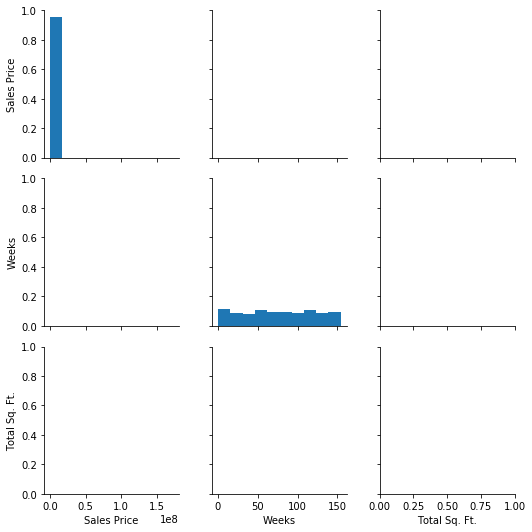

In [809]:
seaborn.pairplot(df[['Sales Price','Weeks','Total Sq. Ft.']])

In [797]:
type((df['Last Sold'].max() - df['Last Sold'].min()).days)

int

## Investigate DataFrame:
- Do overall stats using describe
- Groupby zipcodes and do stats

In [810]:
df.describe()

,Baths,Beds,Sales Price,Stories,Total Sq. Ft.,Unfinished Sq. Ft.,Year Built,Year Renovated,Weeks,Lot Size Sq. Ft.
count,3346.0,3208.0,4236.0,2677.0,3894.0,464.0,3770.0,2850.0,4236.0,2466.0
mean,2.6,3.2,1415660.6,3.1,2190.5,504.6,1957.6,1968.3,75.9,17901.8
std,2.9,3.0,3155168.9,4.2,3256.5,599.9,31.5,26.8,45.1,52839.7
min,1.0,1.0,210.0,1.0,153.0,0.0,1875.0,1899.0,0.0,1.0
25%,1.5,2.0,545000.0,1.0,1141.0,0.0,1930.0,1953.0,37.0,4683.0
50%,2.0,3.0,954781.5,2.0,1667.5,518.0,1959.0,1971.0,75.0,7169.5
75%,3.0,4.0,1595000.0,3.0,2404.8,800.2,1980.0,1987.0,115.0,12196.8
max,59.0,59.0,172500000.0,31.0,141498.0,10000.0,2016.0,2018.0,154.0,702622.8


In [811]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4236 entries, 0 to 4892
Data columns (total 15 columns):
Baths                 3346 non-null float64
Beds                  3208 non-null float64
County                4236 non-null object
Last Sold             4236 non-null datetime64[ns]
Sales Price           4236 non-null float64
Stories               2677 non-null float64
Style                 4236 non-null object
Total Sq. Ft.         3894 non-null float64
Unfinished Sq. Ft.    464 non-null float64
Year Built            3770 non-null float64
Year Renovated        2850 non-null float64
Zip Code              4236 non-null object
rURL                  4236 non-null object
Weeks                 4236 non-null int64
Lot Size Sq. Ft.      2466 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(1), object(4)
memory usage: 689.5+ KB


In [689]:
group = df.groupby(['Style']).agg(['mean','std','sem'])
group

Baths         Beds          Sales Price             \
                           mean std sem mean  std sem        mean        std   
Style                                                                          
Condo/Co-op                 1.9 0.8 0.0  1.9  0.7 0.0   1135901.4  1116199.2   
Multi-Family (2-4 Unit)     4.3 5.2 0.4  6.0  5.8 0.4   1632218.3  1547841.8   
Multi-Family (5+ Unit)     11.5 9.5 1.0 14.0 10.1 1.1   4841726.0 14242083.0   
Single Family Residential   2.2 1.2 0.0  3.2  1.0 0.0   1349915.3  1745991.0   
Townhouse                   2.6 0.6 0.0  2.4  0.6 0.0   1135429.3   744639.1   

                                    Stories         Total Sq. Ft.          \
                                sem    mean std sem          mean     std   
Style                                                                       
Condo/Co-op                 27792.3     7.4 6.5 0.2        1228.2   574.3   
Multi-Family (2-4 Unit)     88053.6     2.2 0.8 0.1        3245.0  3092.0   
Multi-Family (5+ Unit)    1143951.6     3.6 1.9 0.2        8917.3 13389.0   
Single Family Residential   38886.3     1.4 0.6 0.0        2228.1  1264.5   
Townhouse                   47380.3     2.3 0.9 0.2        1679.6   529.3   

                                 Unfinished Sq. Ft.             Year Built  \
                             sem               mean   std   sem       mean   
Style                                                                        
Condo/Co-op                 15.7               72.6 234.2  38.5     1973.7   
Multi-Family (2-4 Unit)    179.4              243.0 486.0 243.0     1929.6   
Multi-Family (5+ Unit)    1096.9            10000.0   nan   nan     1938.6   
Single Family Residential   28.4              540.8 391.4  19.1     1950.2   
Townhouse                   34.8                0.0   0.0   0.0     1982.2   

                                   Year Renovated          Lot Size Sq. Ft.  \
                           std sem           mean  std sem             mean   
Style                                                                         
Condo/Co-op               30.4 0.9         1981.7 16.9 0.6          14610.0   
Multi-Family (2-4 Unit)   26.3 1.5         1936.0 30.0 2.1           5718.6   
Multi-Family (5+ Unit)    31.6 2.6         1964.0 21.2 2.3           6808.0   
Single Family Residential 26.7 0.6         1963.6 26.9 0.7          15918.6   
Townhouse                 20.0 1.3         1984.1 17.0 1.1          65077.5   

                                            
                               std     sem  
Style                                       
Condo/Co-op                16300.2 11526.0  
Multi-Family (2-4 Unit)     5591.9   326.1  
Multi-Family (5+ Unit)      5587.8   457.8  
Single Family Residential  41655.7   961.0  
Townhouse                 130116.2  8873.8

In [690]:
df.groupby(['Style']).agg(['mean','std','sem'])



Baths         Beds          Sales Price             \
                           mean std sem mean  std sem        mean        std   
Style                                                                          
Condo/Co-op                 1.9 0.8 0.0  1.9  0.7 0.0   1135901.4  1116199.2   
Multi-Family (2-4 Unit)     4.3 5.2 0.4  6.0  5.8 0.4   1632218.3  1547841.8   
Multi-Family (5+ Unit)     11.5 9.5 1.0 14.0 10.1 1.1   4841726.0 14242083.0   
Single Family Residential   2.2 1.2 0.0  3.2  1.0 0.0   1349915.3  1745991.0   
Townhouse                   2.6 0.6 0.0  2.4  0.6 0.0   1135429.3   744639.1   

                                    Stories         Total Sq. Ft.          \
                                sem    mean std sem          mean     std   
Style                                                                       
Condo/Co-op                 27792.3     7.4 6.5 0.2        1228.2   574.3   
Multi-Family (2-4 Unit)     88053.6     2.2 0.8 0.1        3245.0  3092.0   
Multi-Family (5+ Unit)    1143951.6     3.6 1.9 0.2        8917.3 13389.0   
Single Family Residential   38886.3     1.4 0.6 0.0        2228.1  1264.5   
Townhouse                   47380.3     2.3 0.9 0.2        1679.6   529.3   

                                 Unfinished Sq. Ft.             Year Built  \
                             sem               mean   std   sem       mean   
Style                                                                        
Condo/Co-op                 15.7               72.6 234.2  38.5     1973.7   
Multi-Family (2-4 Unit)    179.4              243.0 486.0 243.0     1929.6   
Multi-Family (5+ Unit)    1096.9            10000.0   nan   nan     1938.6   
Single Family Residential   28.4              540.8 391.4  19.1     1950.2   
Townhouse                   34.8                0.0   0.0   0.0     1982.2   

                                   Year Renovated          Lot Size Sq. Ft.  \
                           std sem           mean  std sem             mean   
Style                                                                         
Condo/Co-op               30.4 0.9         1981.7 16.9 0.6          14610.0   
Multi-Family (2-4 Unit)   26.3 1.5         1936.0 30.0 2.1           5718.6   
Multi-Family (5+ Unit)    31.6 2.6         1964.0 21.2 2.3           6808.0   
Single Family Residential 26.7 0.6         1963.6 26.9 0.7          15918.6   
Townhouse                 20.0 1.3         1984.1 17.0 1.1          65077.5   

                                            
                               std     sem  
Style                                       
Condo/Co-op                16300.2 11526.0  
Multi-Family (2-4 Unit)     5591.9   326.1  
Multi-Family (5+ Unit)      5587.8   457.8  
Single Family Residential  41655.7   961.0  
Townhouse                 130116.2  8873.8

In [691]:
df['Style'].unique()

array(['Multi-Family (2-4 Unit)', 'Single Family Residential',
       'Condo/Co-op', 'Multi-Family (5+ Unit)', 'Townhouse'], dtype=object)

In [692]:
df['Style'].nunique()

5

In [695]:
df['Style'].value_counts()

Single Family Residential    2016
Condo/Co-op                  1613
Multi-Family (2-4 Unit)       309
Townhouse                     247
Multi-Family (5+ Unit)        155
Name: Style, dtype: int64

In [701]:
df = df[df['Sales Price']<25000000]

In [702]:
df.groupby(['Style']).mean()

,Baths,Beds,Sales Price,Stories,Total Sq. Ft.,Unfinished Sq. Ft.,Year Built,Year Renovated,Lot Size Sq. Ft.
Style,,,,,,,,,
Condo/Co-op,1.9,1.9,1135901.4,7.4,1228.2,72.6,1973.7,1981.7,14610.0
Multi-Family (2-4 Unit),4.3,6.0,1632218.3,2.2,3245.0,243.0,1929.6,1936.0,5718.6
Multi-Family (5+ Unit),11.5,14.0,3496519.8,3.4,7568.7,10000.0,1938.2,1963.7,6666.5
Single Family Residential,2.2,3.2,1349915.3,1.4,2228.1,540.8,1950.2,1963.6,15918.6
Townhouse,2.6,2.4,1135429.3,2.3,1679.6,0.0,1982.2,1984.1,65077.5


In [713]:
df['log Sales Price'] = df['Sales Price'].map(np.log10)

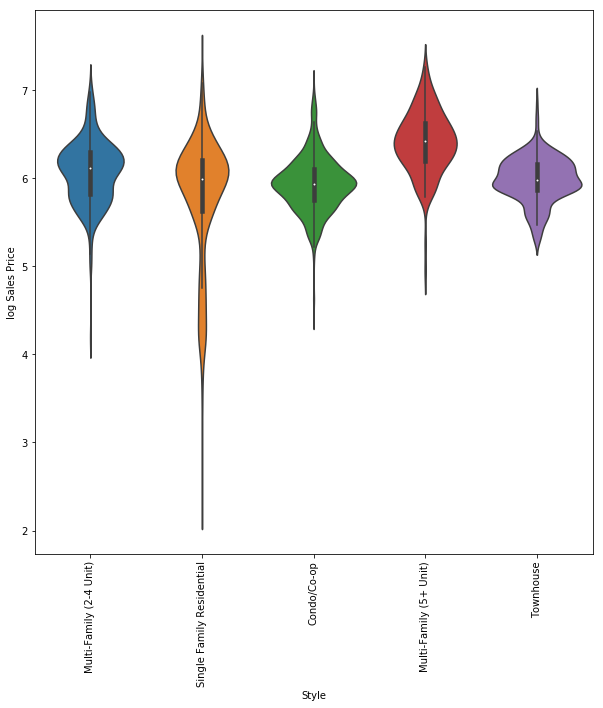

In [716]:
fig, ax = plt.subplots(figsize=(10,10))
seaborn.violinplot(x="Style", y="log Sales Price", data=df, jitter=True)
plt.xticks(rotation='vertical');

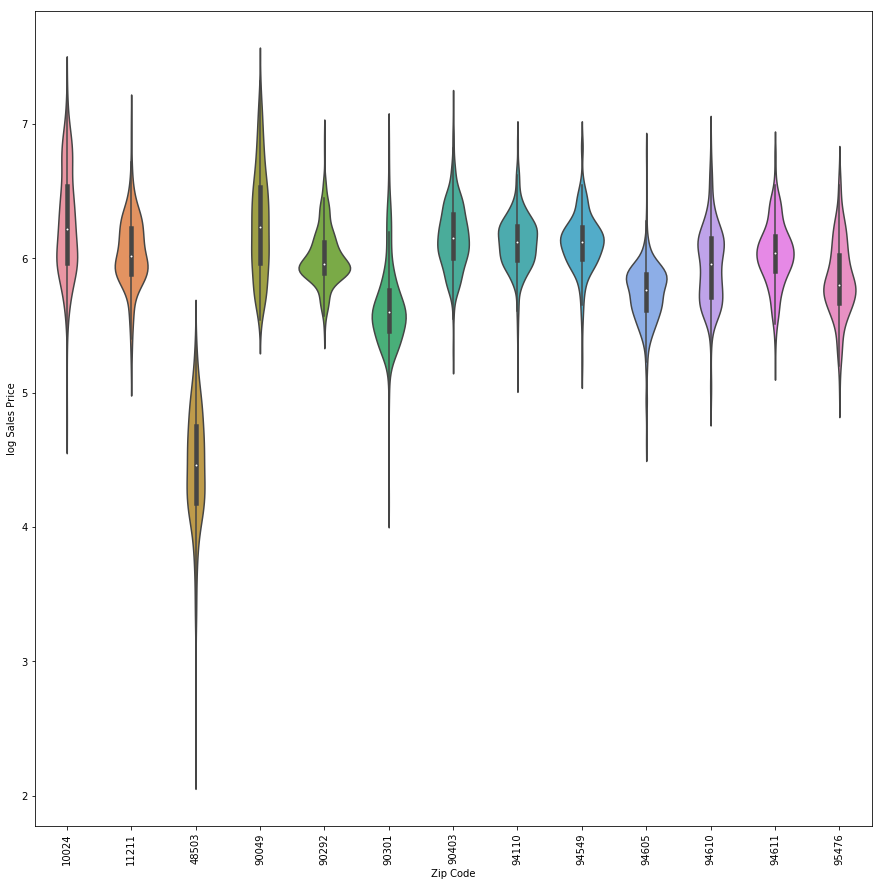

In [715]:
fig, ax = plt.subplots(figsize=(15,15))
seaborn.violinplot(x="Zip Code", y="log Sales Price", data=df, jitter=True)
plt.xticks(rotation='vertical');

In [743]:
df.corr()

,Baths,Beds,Sales Price,Stories,Total Sq. Ft.,Unfinished Sq. Ft.,Year Built,Year Renovated,Lot Size Sq. Ft.,log Sales Price
Baths,1.0,0.9,0.5,0.1,0.8,0.5,0.1,0.1,0.0,0.3
Beds,0.9,1.0,0.4,0.1,0.8,0.1,-0.0,-0.0,-0.0,0.2
Sales Price,0.5,0.4,1.0,0.1,0.6,-0.2,-0.0,0.1,0.1,0.7
Stories,0.1,0.1,0.1,1.0,-0.1,0.3,0.1,0.1,-0.1,0.1
Total Sq. Ft.,0.8,0.8,0.6,-0.1,1.0,0.8,-0.1,0.0,0.0,0.3
Unfinished Sq. Ft.,0.5,0.1,-0.2,0.3,0.8,1.0,-0.2,0.1,-0.0,-0.4
Year Built,0.1,-0.0,-0.0,0.1,-0.1,-0.2,1.0,0.8,0.2,0.1
Year Renovated,0.1,-0.0,0.1,0.1,0.0,0.1,0.8,1.0,0.2,0.1
Lot Size Sq. Ft.,0.0,-0.0,0.1,-0.1,0.0,-0.0,0.2,0.2,1.0,0.1
log Sales Price,0.3,0.2,0.7,0.1,0.3,-0.4,0.1,0.1,0.1,1.0


In [770]:
from datetime import datetime
(df['Last Sold'] > datetime.strptime('2014-05-01', '%Y-%m-%d')).value_counts()

True     4303
False      35
Name: Last Sold, dtype: int64

## Feature Engineering:


#TODO: break out a `homepricemodels.py` script. Accepts a clean/readable data frame. Creates models, analyses, plots for EDA as well as model assessment.
- Feature Engineering functions incl.:
    - add column of `Month`
    - add columns of `Year`
    - Diagnostic plots: plot bar/hist of occurences of `Month`
    - develop grouping/function of `Season` that captures On and Off seasons?

#TODO: plan a datastructure for keeping models (dependent on redfin.py):
- Create a dict of dataframes, one df for each model: `df_dict`
- Create a dict of models, one `OLS` for each df in: `model_dict` Same keys as df_dict?
- Create plot functions that work for each model: predicted vs actual; residuals, 

### Linear Regression and Train/Test Split challenges

Ideally, try these with your own data! (Alternatively, there is the
`2013_movies.csv` data set.)

#### Challenge 1

Build a linear model that uses only a constant term (a column of ones) to predict a continuous outcome (like domestic total gross). How can you interpret the results of this model? What does it predict? Make a plot of predictions against actual outcome. Make a histogram of residuals. How are the residuals distributed?

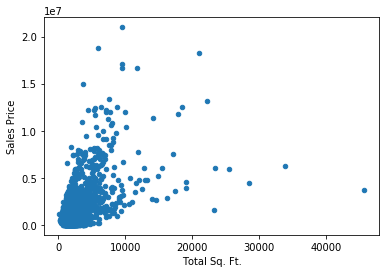

In [724]:
df[['Total Sq. Ft.','Sales Price']].plot(x='Total Sq. Ft.',y='Sales Price',kind='scatter')

Int64Index([   0,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            4882, 4883, 4884, 4885, 4887, 4888, 4889, 4890, 4891, 4892],
           dtype='int64', length=4338)

In [750]:
import statsmodels.api as sm

Y = df['Sales Price']

X = pd.Series(1, index=df['Sales Price'].index)

model = sm.OLS(X,Y).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     3070.
Date:                Mon, 23 Apr 2018   Prob (F-statistic):               0.00
Time:                        21:09:49   Log-Likelihood:                -4994.5
No. Observations:                4338   AIC:                             9991.
Df Residuals:                    4337   BIC:                             9997.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Sales Price  3.061e-07   5.52e-09     55.406      0.000    2.95e-07    3.17e-07
==============================================================================
Omnibus:                     4000.105   Durbin-Watson:                   0.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           168997.615
Skew:                          -4.404   Prob(JB):                         0.00
Kurtosis:                      32.282   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
model.predict(1000)

In [738]:
df['Sales Price'].mean()

1353944.7113877363

#### Challenge 2

Repeat the process of challenge one, but also add one continuous (numeric) predictor variable. Also add plots of model prediction against your feature variable and residuals against feature variable. How can you interpret what's happening in the model?

In [751]:
X = df['Total Sq. Ft.'].
Y = df['Sales Price']

model2 = sm.OLS(X,Y).fit()
model2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total Sq. Ft.   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 23 Apr 2018   Prob (F-statistic):                nan
Time:                        21:10:12   Log-Likelihood:                    nan
No. Observations:                4338   AIC:                               nan
Df Residuals:                    4337   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Sales Price        nan        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""





#### Challenge 3

Repeat the process of challenge 1, but add a categorical feature (like genre). You'll have to convert a column of text into a number of numerical columns ("dummy variables"). How can you interpret what's happening in the model?

#### Challenge 4

Enhance your model further by adding more features and/or transforming existing features. Think about how you build the model matrix and how to interpret what the model is doing.

#### Challenge 5

Fitting and checking predictions on the exact same data set can be
misleading. Divide your data into two sets: a training and a test set
(roughly 75% training, 25% test is a fine split). Fit a model on the
training set, check the predictions (by plotting versus actual values)
in the test set.